# Определение перспективного тарифа для телеком компании

В нашем распоряжении данные компании — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, нужно проанализировать, какой тариф приносит больше денег.
Предоставлены данные 500 пользователей, содержащие следующие сведения: возраст, город проживания, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф приносит компании больше средств.

## Изучение данных из файла

Загрузим библиотеки, которые понадобятся.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy import stats as st
from scipy.stats import norm
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

Прочитаем файлы csv и сохраним его в соответствующих переменных.

In [2]:
try:
    calls = pd.read_csv('/datasets/calls.csv')
except:
    calls = pd.read_csv('calls.csv')
display(calls.head(5))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица calls (информация о звонках):

•	id — уникальный номер звонка

•	call_date — дата звонка

•	duration — длительность звонка в минутах

•	user_id — идентификатор пользователя, сделавшего звонок

In [3]:
print('Общее число записей calls:')
print(calls.shape[0])
print()
print(calls.info())

Общее число записей calls:
202607

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


In [4]:
print('Максимальная длительность звонка:')
calls['duration'].max()

Максимальная длительность звонка:


38.0

Максимальная длительность звонка не похожа на аномальную, ошибок нет.

In [5]:
print('Количество звонков с нулевой длительностью:')
calls.query('duration == 0.00').shape[0]

Количество звонков с нулевой длительностью:


39613

Звонки длительностью 0.00 могут быть пропущенными, либо клиент не пользовался звонками, а использовал симку для интернета. При расчете дисперсии, стандартного отклонения их не стоит принимать во внимание.

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Поэтому округлим значения в столбце duration до минуты и приведем к типу int. 

Данные следует сгруппировать по user_id и по отдельному стобцу month. Тип данных call_date следует преобразовать в datetime

In [6]:
try:
    internet = pd.read_csv('/datasets/internet.csv')
except:
    internet = pd.read_csv('internet.csv')
display(internet.head(5))

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Таблица internet (информация об интернет-сессиях):

•	id — уникальный номер сессии

•	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

•	session_date — дата интернет-сессии

•	user_id — идентификатор пользователя

In [7]:
print('Общее число записей internet:')
print(internet.shape[0])
print()
print(internet.info())

Общее число записей internet:
149396

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None


In [8]:
print('Максимальная количество мегабайтов:')
internet['mb_used'].max()

Максимальная количество мегабайтов:


1724.83

Максимальная количество мегабайтов не похоже на аномальное значение, оставляем.

In [9]:
print('Количество записей с потраченным за сессию нулевым интернет-трафиком:')
internet.query('mb_used == 0.00').shape[0]

Количество записей с потраченным за сессию нулевым интернет-трафиком:


19598

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Поэтому данные сперва следует сгруппировать по user_id и по отдельному стобцу month, а потом округлить до Гб столбец mb_used и привести его к типу int. Данные с нулевым трафиком, вероятно, означают, что пользователь не пользовался интернетом.
Тип данных session_date следует преобразовать в datetime

In [10]:
try:
    messages = pd.read_csv('/datasets/messages.csv')
except:
    messages = pd.read_csv('messages.csv')
display(messages.head(5))

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица messages (информация о сообщениях):

•	id — уникальный номер сообщения

•	message_date — дата сообщения

•	user_id — идентификатор пользователя, отправившего сообщение


In [11]:
print('Общее число записей messages:')
print(messages.shape[0])
print()
print(messages.info())

Общее число записей messages:
123036

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


Данные следует сгруппировать по user_id и по отдельному стобцу month. Тип данных message_date следует преобразовать в datetime

In [12]:
try:
    tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    tariffs = pd.read_csv('tariffs.csv')
display(tariffs.head(5))

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):

•	tariff_name — название тарифа

•	rub_monthly_fee — ежемесячная абонентская плата в рублях

•	minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

•	messages_included — количество сообщений в месяц, включённых в абонентскую плату

•	mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

•	rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

•	rub_per_message — стоимость отправки сообщения сверх тарифного пакета

•	rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Эта сводная информационна таблица о типах тарифов. Данные представлены в мб, следует перевести в гб.

In [13]:
try:
    users = pd.read_csv('/datasets/users.csv')
except:
    users = pd.read_csv('users.csv')
display(users.head(5))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблица users (информация о пользователях):

•	user_id — уникальный идентификатор пользователя

•	first_name — имя пользователя

•	last_name — фамилия пользователя

•	age — возраст пользователя (годы)

•	reg_date — дата подключения тарифа (день, месяц, год)

•	churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

•	city — город проживания пользователя

•	tariff — название тарифного плана

In [14]:
print('Общее число записей users:')
print(users.shape[0])
print()
print(users.info())

Общее число записей users:
500

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [15]:
print('Уникальных пользователей:')
print(users['user_id'].unique().shape[0])
print('Уникальных тарифов:')
print(users['tariff'].unique())

Уникальных пользователей:
500
Уникальных тарифов:
['ultra' 'smart']


Из пятисот строк в столбце churn_date  много пропусков, их можно заполнить датой выгрузки. Уникальных user_id действительно 500, ошибок нет, тарифов также всего два. Необходимо перевести данные по дате в формат datetime

#### Вывод 

Мы изучаем данные 500 пользователей сети Мегалайн за 2018 год: откуда они, сколько тратят на услуги оператора в месяц, сколько сообщений отправляют, сколько совершают звонков и сколько используют интернет. 
Нужно установить, какой из тарифов ultra или smart выгоднее для компании, проанализировав поведение клиентов.

План работ:

Чтобы провести анализ, данные сперва необходимо обработать: удалить нулевые значения, заполнить пропуски, сгруппировать таблицы по user_id, month, свести таблицы в одну.

Далее для каждого пользователя нужно оценить:

•	количество сделанных звонков и израсходованных минут разговора по месяцам;

•	количество отправленных сообщений по месяцам;

•	объем израсходованного интернет-трафика по месяцам;

•	помесячную выручку с каждого пользователя.

После этого, для каждого тарифа следует описать потребности клиентов: сколько минут разговора, сколько сообщений и какой объём интернет-трафика необходим пользователям каждого тарифа в месяц. 

На заключительном этапе исследования проверим гипотезы:

•	средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

•	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

## Предобработка данных

Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Поэтому округлим значения в столбце duration до минуты и приведем к типу int. Данные следует сгруппировать по user_id и по отдельному стобцу month. Тип данных call_date следует преобразовать в datetime

In [16]:
display(calls.head(5))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [17]:
#Фунцкция, округляющая значения до минут
def in_min(row):
    return math.ceil(row['duration'])

#Применяем функцию, преобразуем столбец in_min к типу int
calls['duration'] = calls.apply(in_min, axis = 1).astype(int)

In [18]:
display(calls.head(3))
print('Всего записей:')
display(calls.shape[0])

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000


Всего записей:


202607

In [19]:
# Преобразуем формат object в datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
#Добавляем столбец с месяцем 
calls['month'] = calls['call_date'].dt.month
display(calls.head(3))

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6


In [20]:
#Сгруппируем данные по user_id, month, чтобы посчитать количество минут на каждого пользователя
calls_piv = calls.pivot_table(index = ['user_id','month'], values = ['duration'], aggfunc = 'sum')
#calls_piv = calls_piv.reset_index()
calls_piv

duration
user_id month          
1000    5           159
        6           172
        7           340
        8           408
        9           466
...                 ...
1498    10          247
1499    9            70
        10          449
        11          612
        12          492

[3174 rows x 1 columns]

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Поэтому данные сперва следует сгруппировать по user_id и по отдельному стобцу month, а потом округлить до Гб столбец mb_used в целых числах. Данные с нулевым трафиком, вероятно, означают, что пользователь не пользовался интернетом.
Тип данных session_date следует преобразовать в datetime

In [21]:
display(internet.head(5))

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [22]:
# Преобразуем формат object в datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
#Добавляем столбец с месяцем 
internet['month'] = internet['session_date'].dt.month
internet

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,10
149392,149392,1499_153,490.13,2018-12-14,1499,12
149393,149393,1499_154,0.00,2018-10-27,1499,10
149394,149394,1499_155,1246.32,2018-11-26,1499,11


In [23]:
#Сгруппируем данные по user_id, month, чтобы посчитать количество мегабайт на каждого пользователя
internet_piv = internet.pivot_table(index = ['user_id', 'month'], values = ['mb_used'], aggfunc = 'sum')
internet_piv

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

In [24]:
#Фунцкция, округляющая значения вверх до Гб
def in_Gb(row):
    row['mb_used'] = row['mb_used']/1024
    return math.ceil(row['mb_used'])
     
#Применяем функцию, преобразуем столбец mb_used в gb_used
internet_piv['mb_used'] = internet_piv.apply(in_Gb, axis = 1)
internet_piv.columns = ['gb_used']
internet_piv

gb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
...                ...
1498    10          21
1499    9            2
        10          18
        11          18
        12          13

[3203 rows x 1 columns]

Сгруппируем данные messages по user_id и по отдельному стобцу month.
Тип данных session_date следует преобразовать в datetime

In [25]:
# Преобразуем формат object в datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
#Добавляем столбец с месяцем 
messages['month'] = messages['message_date'].dt.month
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [26]:
#Сгруппируем данные по user_id, month, чтобы посчитать количество сообщений на каждого пользователя в месяц
messages_piv = messages.pivot_table(index = ['user_id', 'month'], values = ['message_date'], aggfunc = 'count')
#messages_piv = messages_piv.reset_index()
messages_piv.columns = ['messages']
messages_piv

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

#### Вывод
Теперь у нас есть таблицы, сгруппированные по user_id с данными по сообщениям, продолжительности звонков и интернет-сессий в гб. В таблицах разное число строк, вероятно, пропущены данные для некоторых пользователей. Объединим таблицы.

### Расчёты и объединение таблиц

In [27]:
#Объединяем таблицы с данными по звонкам и интернет-сессиям
calls_intr=calls_piv.merge(internet_piv, on=['user_id','month'], how='outer')
calls_intr

duration  gb_used
user_id month                   
1000    5         159.0      3.0
        6         172.0     23.0
        7         340.0     14.0
        8         408.0     14.0
        9         466.0     15.0
...                 ...      ...
1489    8           NaN     11.0
        9           NaN     17.0
        10          NaN     20.0
        11          NaN     18.0
        12          NaN     17.0

[3214 rows x 2 columns]

In [28]:
#Объединяем предыдущую таблицу с таблицей по сообщениям
calls_intr_mes=calls_intr.merge(messages_piv, on=['user_id','month'], how='outer')
calls_intr_mes = calls_intr_mes.reset_index()
calls_intr_mes.head(10)

,user_id,month,duration,gb_used,messages
0,1000,5,159.0,3.0,22.0
1,1000,6,172.0,23.0,60.0
2,1000,7,340.0,14.0,75.0
3,1000,8,408.0,14.0,81.0
4,1000,9,466.0,15.0,57.0
5,1000,10,350.0,15.0,73.0
6,1000,11,338.0,15.0,58.0
7,1000,12,333.0,10.0,70.0
8,1001,11,430.0,18.0,NaN
9,1001,12,414.0,14.0,NaN


Переведем в таблице тарифов данные в гб.

In [29]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype(int)
tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name']
tariffs

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


Из пятисот строк в таблице users в столбце churn_date  много пропусков, их можно заполнить датой выгрузки и необходимо перевести данные по дате в формат datetime.

In [30]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Посмотрим, какова максимальная и минимальная дата, нет ли ошибок.

In [31]:
print('Максимальная дата:')
print(users['reg_date'].max())
print('Минимальная дата:')
print(users['reg_date'].min())

Максимальная дата:
2018-12-31
Минимальная дата:
2018-01-01


Если минимальная дата подключения это уже 2018 год, то можно из максимальной даты вычесть минимальную. 
Заменим пропущенные данные в столбце churn_date на максимальную дату 2018-12-31, тк нас интересуют данные за 2018 год

In [32]:
# Заполняем данные 
users['churn_date'] = users['churn_date'].fillna('2018-12-31')

# Преобразуем формат object в datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2018-12-31,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2018-12-31,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2018-12-31,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Объединим таблицу с таблицей calls_intr_mes

In [33]:
data=users.merge(calls_intr_mes, on='user_id', how='right')
data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,gb_used,messages
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159.0,3.0,22.0
1,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172.0,23.0,60.0
2,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340.0,14.0,75.0
3,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408.0,14.0,81.0
4,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466.0,15.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,NaN,11.0,17.0
3210,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,9,NaN,17.0,32.0
3211,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,10,NaN,20.0,21.0
3212,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,11,NaN,18.0,20.0


Проверим сколько значений Nan  осталось в таблице и заменим их на 0, поскольку этой услугой клиент в данном месяце не пользовался

In [34]:
print('Количество нулевых значений:')
print(data.isna().sum())

Количество нулевых значений:
user_id         0
age             0
churn_date      0
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
month           0
duration       40
gb_used        11
messages      497
dtype: int64


In [35]:
# заменим пропуски на 0
data['duration'] = data['duration'].fillna(0)
data['gb_used'] = data['gb_used'].fillna(0)
data['messages'] = data['messages'].fillna(0)

# приведем данные в этих столбцах к типу int
data[['duration', 'gb_used', 'messages']] = data[['duration', 'gb_used', 'messages']].astype(int)
data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,gb_used,messages
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159,3,22
1,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172,23,60
2,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340,14,75
3,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408,14,81
4,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466,15,57
...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,0,11,17
3210,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,9,0,17,32
3211,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,10,0,20,21
3212,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,11,0,18,20


In [36]:
print('Таблица тарифов:')
tariffs

Таблица тарифов:


,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15,500,550,200,3,3,smart
1,1000,30,3000,1950,150,1,1,ultra


Расчитаем помесячную выручку с каждого пользователя 

In [37]:
#функция считает выручку с каждого пользователя
#вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика 
#остаток умножаем на значение из тарифного плана
#прибаляем абонентскую плату, соответствующую тарифному плану

def revenue(row):
    revenue_month = 0
    if row['tariff'] == 'ultra':
        if row['duration'] > (tariffs.loc[1, 'minutes_included']):
            revenue_month += (tariffs.loc[1, 'rub_per_minute'] * (row['duration']  - tariffs.loc[1, 'minutes_included']))
        if row['gb_used'] > (tariffs.loc[1, 'gb_per_month_included']):
            revenue_month += (tariffs.loc[1, 'rub_per_gb'] * (row['gb_used']  - tariffs.loc[1, 'gb_per_month_included']))
        if row['messages'] > (tariffs.loc[1, 'messages_included']):
            revenue_month += (tariffs.loc[1, 'rub_per_message'] * (row['messages']  - tariffs.loc[1, 'messages_included']))
        revenue_month += tariffs.loc[1, 'rub_monthly_fee']
    else:
        if row['duration'] > (tariffs.loc[0, 'minutes_included']):
            revenue_month += (tariffs.loc[0, 'rub_per_minute'] * (row['duration']  - tariffs.loc[0, 'minutes_included']))
        if row['gb_used'] > (tariffs.loc[0, 'gb_per_month_included']):
            revenue_month += (tariffs.loc[0, 'rub_per_gb'] * (row['gb_used']  - tariffs.loc[0, 'gb_per_month_included']))
        if row['messages'] > (tariffs.loc[0, 'messages_included']):
            revenue_month += (tariffs.loc[0, 'rub_per_message'] * (row['messages']  - tariffs.loc[0, 'messages_included']))  
        revenue_month += tariffs.loc[0, 'rub_monthly_fee']
    return revenue_month


In [38]:
# Рассчитаем выручку по месяцам для каждого абонента
data['revenue_month'] = data.apply(revenue, axis = 1)
data

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,gb_used,messages,revenue_month
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159,3,22,1950
1,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172,23,60,1950
2,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340,14,75,1950
3,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408,14,81,1950
4,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466,15,57,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8,0,11,17,550
3210,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,9,0,17,32,950
3211,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,10,0,20,21,1550
3212,1489,35,2018-12-31,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,11,0,18,20,1150


#### Вывод

Избавились в данных от пропущенных значений, привели их к нужному формату и одинаковым единицам измерения. 

Для каждого пользователя посчитано: 

•	количество сделанных звонков и израсходованных минут разговора по месяцам;

•	количество отправленных сообщений по месяцам;

•	объем израсходованного интернет-трафика по месяцам;

•	помесячную выручку с каждого пользователя.

Объединили таблицы.  Теперь данные пригодны для анализа. 

## Исследовательский анализ данных

Посмотрим, влияет ли возраст клиента на показатель выручки для разных тарифов

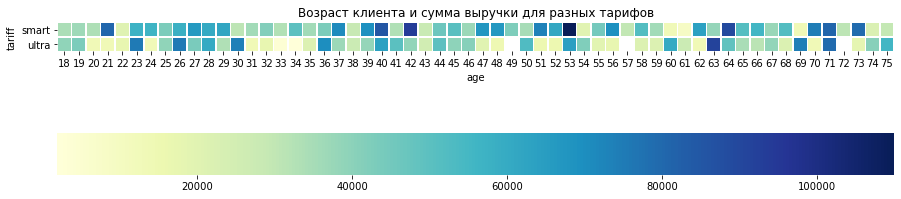

In [39]:
#Возраст клиента и показатель выручки для разных тарифов
data_age = data.pivot_table(
                        index=data['tariff'], 
                        columns='age',
                        values= 'revenue_month', 
                        aggfunc='sum')
plt.figure(figsize=(15,10))
g = sns.heatmap(data_age, annot=False, fmt=".0f", linewidths=.5, cmap="YlGnBu", square = True, cbar_kws={"orientation": "horizontal"})
plt.title('Возраст клиента и сумма выручки для разных тарифов')
plt.show()


Явной зависимости от возраста не прослеживается. Самые молодые и самые возрастные клиенты не лидеры по выручке. 

In [40]:
#Соберем данные об абонентах, кто по тарифу smart платил сверх абонентской платы
data_over_sm=data.query('revenue_month > 550 & revenue_month < 1950').pivot_table(index="last_name", values='revenue_month', aggfunc='sum' ).astype(int)

#Выручка, полученная сверх абонентской платы по ним
revenue_over_smart = data_over_sm['revenue_month'].sum() - (tariffs.loc[0, 'rub_monthly_fee'] * data_over_sm.shape[0])

#Выручка, полученная по абонентской плате по всем абонентам
revenue_on_smart = data.query('tariff == "smart"').shape[0] * tariffs.loc[0, 'rub_monthly_fee']

print('Доход по абонентской плате тарифа smart -', revenue_on_smart)
print('Доход сверх абонентской платы тарифа smart -', revenue_over_smart)

Доход по абонентской плате тарифа smart - 1225950
Доход сверх абонентской платы тарифа smart - 1201099


In [41]:
#Соберем данные об абонентах, кто по тарифу ultra платил сверх абонентской платы
data_over_ul=data.query('revenue_month >  1950').pivot_table(index="last_name", values='revenue_month', aggfunc='sum' ).astype(int)

#Выручка, полученная сверх абонентской платы по ним
revenue_over_ultra = data_over_ul['revenue_month'].sum() - (tariffs.loc[1, 'rub_monthly_fee'] * data_over_ul.shape[0])

#Выручка, полученная по абонентской плате по всем абонентам
revenue_on_ultra = data.query('tariff == "ultra"').shape[0] * tariffs.loc[1, 'rub_monthly_fee']

print('Доход по абонентской плате тарифа ultra -', revenue_on_ultra)
print('Доход сверх абонентской платы тарифа ultra -', revenue_over_ultra)

Доход по абонентской плате тарифа ultra - 1920750
Доход сверх абонентской платы тарифа ultra - 1102752


Получили данные, что по тарифу smart выручка, полученная по абонентской плате примерно равна выручке за услуги не включенные в абонентскую плату. По тарифу ultra переплат сверх тарифа меньше.

Проанализируем данные, опишем поведение клиентов оператора по разным тарифам. 
Посчитаем, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. 

In [42]:
# Посмотрим, сколько клиентов не пользуется звонками
no_dur = 1 - ( data.query('duration != 0').shape[0])/data.shape[0]
print('Не используют  : {:.1%} клиентов'.format(no_dur))

Не используют  : 1.4% клиентов


Почти все клиенты пользуются звонками. Вероятно, 1,4% испольуют симки для интернета. 
Рассмотрим только те строки, в которых есть данные о количестве минут. 
Уберем строки в которых количество минут = 0, 

In [43]:
data_dur = data.query('duration != 0')
#Сколько минут разговора требуется пользователям каждого тарифа в месяц
data_dur.groupby('tariff').agg({'duration': 'mean'}).astype(int)

,duration
tariff,
smart,419
ultra,547


In [44]:
#Сколько минут разговора предоставляется пользователям каждого тарифа в рамках абонентской платы
tariffs[['minutes_included', 'tariff_name']]

,minutes_included,tariff_name
0,500,smart
1,3000,ultra


Хотя пользователи ultra и звонят, в среднем больше, чем smart но в рамках тарифов им предоставляется 3000, что намного выше среднего. 

In [45]:
# Дисперсия и стандартное отклонение для продолжительности звонков тарифа ultra
variance = np.var(data_dur.query('tariff == "ultra"')['duration'])
standard_deviation = np.std(data_dur.query('tariff == "ultra"')['duration'])
mean = (data_dur.query('tariff == "ultra"')['duration'].mean())

print('Дисперсия минут для тарифа ultra -', variance) 
print('Стандартное отклонение минут для тарифа ultra -', standard_deviation) 
print('Среднее для тарифа ultra -', mean) 

Дисперсия минут для тарифа ultra - 93239.8660651264
Стандартное отклонение минут для тарифа ultra - 305.3520362878335
Среднее для тарифа ultra - 547.7550158394931


In [46]:
# Дисперсия и стандартное отклонение для продолжительности звонков тарифа smart
variance = np.var(data_dur.query('tariff == "smart"')['duration'])
standard_deviation = np.std(data_dur.query('tariff == "smart"')['duration'])
mean = (data_dur.query('tariff == "smart"')['duration'].mean())

print('Дисперсия минут для тарифа smart -', variance) 
print('Стандартное отклонение минут для тарифа smart -', standard_deviation) 
print('Среднее для тарифа smart -', mean) 

Дисперсия минут для тарифа smart - 35702.046530995045
Стандартное отклонение минут для тарифа smart - 188.94985189460996
Среднее для тарифа smart - 419.4403421882035


In [47]:
# Дисперсия и стандартное отклонение для обоих тарифов
variance = np.var(data_dur['duration'])
standard_deviation = np.std(data_dur['duration'])
mean = (data_dur['duration'].mean())

print('Дисперсия минут для обоих тарифов -', variance) 
print('Стандартное отклонение минут для обоих тарифов -', standard_deviation) 
print('Среднее для обоих тарифов -', mean) 

Дисперсия минут для обоих тарифов - 56352.13146846863
Стандартное отклонение минут для обоих тарифов - 237.38603890808034
Среднее для обоих тарифов - 457.79703282828285


In [48]:
#Напишем функцию, строящую графики типа distplot
#датасет, название столбца, заголовок графика
    
def print_distplot(x_data, column, title=""):    
    sns.set_style('whitegrid')
    plt.figure(figsize=(12,10))
    ax = sns.distplot(x_data.loc[x_data['tariff'] == 'ultra', column],  bins=50, label='ultra')
    sns.distplot(x_data.loc[x_data['tariff'] == 'smart', column],  bins=50, ax = ax, label='smart')
    plt.axes().set_title(title)
    plt.legend()
    plt.show()    


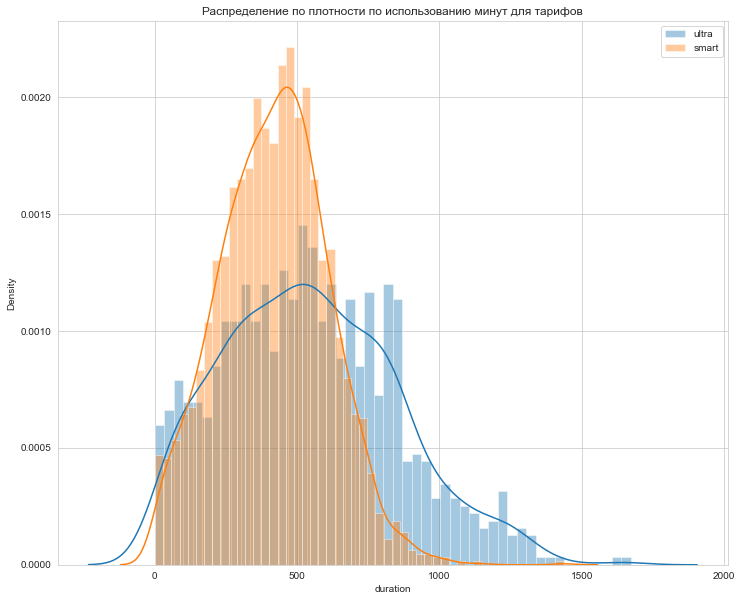

In [49]:
#датасет, название столбца, заголовок графика
print_distplot(data_dur, 'duration', 'Распределение по плотности по использованию минут для тарифов')

Распределения по продолжительности звонков похожи на нормальное. Видно, что с наибольшей вероятностью клиентам нужно около 460 минут в месяц.
Гистограмма по обоим тарифам отображает частоту значений в скошенном вправо наборе данных. Датасет с положительной скошенностью и для тарифа smart и для тарифа ultra. Это означает, что есть данные с продолжительностью звонков значительно большей среднего для обоих тарифов. Распределение для тарифа ultra более пологое, это означает, что разброс значений шире, чем у smart, что также показывает меньшее стандартное отклонение для smart - 189 и для ultra - 305 минут.
По ultra говорят в среднем больше, чем по smart. Среднее для ultra - 548, для smart - 419 минут.

Для тарифа ultra стандартное отклонение составляет 55% от среднего. По тарифу smart эта величнина 44%, что тоже довольно большое значение. 
Это значит, что надо осторожно ориентироваться на среднее, поскольку разброс значений очень велик. Поэтому для оценки средних важно применить статистический тест.

Посмотрим, сколько клиентов не пользуется смс-сообщениями

In [50]:
no_mes = 1 - ( data.query('messages != 0').shape[0])/data.shape[0]
print('Не используют смс-сообщения : {:.1%} клиентов'.format(no_mes))

Не используют смс-сообщения : 15.5% клиентов


Это существенный процент. Рассмотрим только те строки, в которых есть данные о количестве сообщений. 
Уберем строки в которых количество сообщений = 0.

In [51]:
data_mes = data.query('messages != 0')
#Сколько сообщений разговора требуется пользователям каждого тарифа в месяц
data_mes.groupby('tariff').agg({'messages': 'mean'}).astype(int)

,messages
tariff,
smart,38
ultra,61


In [52]:
#Сколько смс предоставляется пользователям каждого тарифа в рамках абонентской платы
tariffs[['messages_included', 'tariff_name']]

,messages_included,tariff_name
0,50,smart
1,1000,ultra


Для ultra допускаемое в рамках тарифа количество смс явно выше необходимого среднего. Для smart значения одного порядка и довольно близки.

In [53]:
# Дисперсия и стандартное отклонение для сообщений тарифа ultra
variance = np.var(data_mes.query('tariff == "ultra"')['messages'])
standard_deviation = np.std(data_mes.query('tariff == "ultra"')['messages'])
mean = (data_mes.query('tariff == "ultra"')['messages'].mean())

print('Дисперсия сообщений для тарифа ultra -', variance) 
print('Стандартное отклонение сообщений для тарифа ultra -', standard_deviation) 
print('Среднее для сообщений тарифа ultra -', mean) 

Дисперсия сообщений для тарифа ultra - 2107.0055235156874
Стандартное отклонение сообщений для тарифа ultra - 45.902129836377824
Среднее для сообщений тарифа ultra - 61.161006289308176


In [54]:
# Дисперсия и стандартное отклонение для сообщений тарифа smart
variance = np.var(data_mes.query('tariff == "smart"')['messages'])
standard_deviation = np.std(data_mes.query('tariff == "smart"')['messages'])
mean = (data_mes.query('tariff == "smart"')['messages'].mean())

print('Дисперсия сообщений для тарифа smart -', variance) 
print('Стандартное отклонение сообщений для тарифа smart -', standard_deviation) 
print('Среднее для сообщений тарифа smart -', mean) 

Дисперсия сообщений для тарифа smart - 717.220843110225
Стандартное отклонение сообщений для тарифа smart - 26.78097912904278
Среднее для сообщений тарифа smart - 38.71644120707596


In [55]:
# Дисперсия и стандартное отклонение для обоих тарифов
variance = np.var(data_mes['messages'])
standard_deviation = np.std(data_mes['messages'])
mean = (data_mes['messages'].mean())

print('Дисперсия смс для обоих тарифов -', variance) 
print('Стандартное отклонение смс для обоих тарифов -', standard_deviation) 
print('Среднее по смс для обоих тарифов -', mean) 

Дисперсия смс для обоих тарифов - 1228.1458278273149
Стандартное отклонение смс для обоих тарифов - 35.044911582529565
Среднее по смс для обоих тарифов - 45.28376886271623


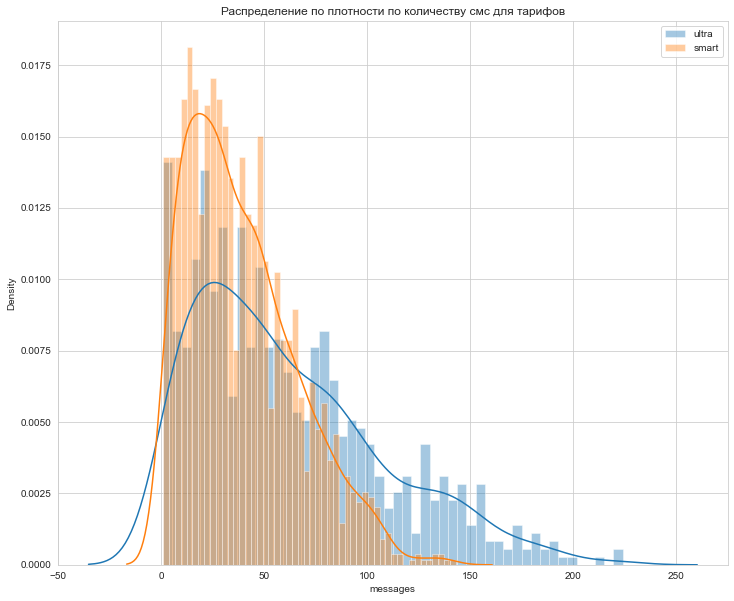

In [56]:
#датасет, название столбца, заголовок графика
print_distplot(data_mes, 'messages', 'Распределение по плотности по количеству смс для тарифов')

Распределение по количеству сообщений существенно скошено вправо. Это говорит о том, что сообщениями все меньше пользуются. Нормальное распределение показывает, что с наибольшей вероятностью, клиенты отправляли около 45смс.

По стандартному отклонению можно понять насколько велик разброс значений в датасете и он практически 70% от среднего по обоим тарифам. Волатильность значений высока. Поэтому для сопоставления средних важно применить статистический тест.

Распределение для тарифа ultra более пологое, это означает, что разброс значений шире, чем у smart.
По тарифу smart чаще используют сообщения, причем укладываются в допустимый лимит по бесплатным смс в рамках тарифа. 
По ultra максимальное кол-во смс около 250, а допускаемое по тарифу - 3000. 

Рассмотрим только те строки, в которых есть данные о количестве гигабайтов интернет-трафика. 
Уберем строки в которых количество гигабайтов = 0, посмотрим, сколько клиентов не пользуется смс-сообщениями

In [57]:
no_gb = 1 - ( data.query('gb_used != 0').shape[0])/data.shape[0]
print('Не используют интернет : {:.1%} клиентов'.format(no_gb))

Не используют интернет : 0.4% клиентов


Почти все используют интернет.

Уберем строки в которых количество гигабайтов = 0.

In [58]:
#Сколько траффика требуется пользователям каждого тарифа в месяц
data_gb = data.query('gb_used != 0')
data_gb.groupby('tariff').agg({'gb_used': 'mean'}).astype(int)

,gb_used
tariff,
smart,16
ultra,19


In [59]:
#Сколько гигабайт предоставляется пользователям каждого тарифа в рамках абонентской платы
tariffs[['gb_per_month_included', 'tariff_name']]

,gb_per_month_included,tariff_name
0,15,smart
1,30,ultra


пользователям ultra в среднем не хватает 1 гб, оператор предоставляет 15 в рамках абонентской платы. Пользователи ultra обеспечены 30 бесплатными гигабайтами, из которых задействуют 19.

In [60]:
# Дисперсия и стандартное отклонение для гигабайтов тарифа ultra
variance = np.var(data_gb.query('tariff == "ultra"')['gb_used'])
standard_deviation = np.std(data_gb.query('tariff == "ultra"')['gb_used'])
mean = (data_gb.query('tariff == "ultra"')['gb_used'].mean())

print('Дисперсия траффика,гб для тарифа ultra -', variance) 
print('Стандартное отклонение траффика,гб для тарифа ultra -', standard_deviation) 
print('Среднее для траффика,гб тарифа ultra -', mean) 

Дисперсия траффика,гб для тарифа ultra - 93.74810367290844
Стандартное отклонение траффика,гб для тарифа ultra - 9.682360439113411
Среднее для траффика,гб тарифа ultra - 19.71457905544148


In [61]:
# Дисперсия и стандартное отклонение для гигабайтов тарифа smart
variance = np.var(data_gb.query('tariff == "smart"')['gb_used'])
standard_deviation = np.std(data_gb.query('tariff == "smart"')['gb_used'])
mean = (data_gb.query('tariff == "smart"')['gb_used'].mean())

print('Дисперсия траффика,гб для тарифа smart -', variance) 
print('Стандартное отклонение траффика,гб для тарифа smart -', standard_deviation) 
print('Среднее для траффика,гб тарифа smart -', mean) 

Дисперсия траффика,гб для тарифа smart - 32.803867867291466
Стандартное отклонение траффика,гб для тарифа smart - 5.7274660948181495
Среднее для траффика,гб тарифа smart - 16.34351145038168


In [62]:
# Дисперсия и стандартное отклонение для обоих тарифов
variance = np.var(data_gb['gb_used'])
standard_deviation = np.std(data_gb['gb_used'])
mean = (data_gb['gb_used'].mean())

print('Дисперсия гб для обоих тарифов -', variance) 
print('Стандартное отклонение гб для обоих тарифов -', standard_deviation) 
print('Среднее по гб для обоих тарифов -', mean) 

Дисперсия гб для обоих тарифов - 53.7536817073624
Стандартное отклонение гб для обоих тарифов - 7.331690235366085
Среднее по гб для обоих тарифов - 17.36925960637301


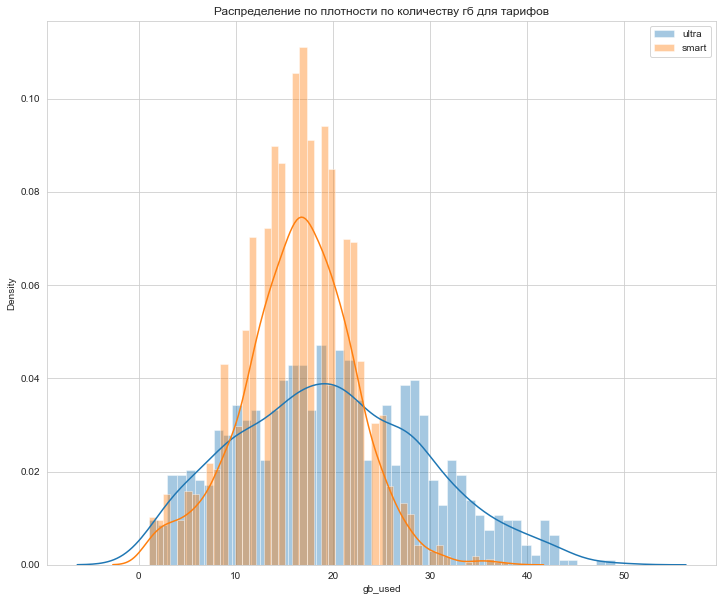

In [63]:
#датасет, название столбца, заголовок графика
print_distplot(data_gb, 'gb_used', 'Распределение по плотности по количеству гб для тарифов')

Распределение по количеству использованных гигабайтов более плавное для пользователей ultra, в то время как для тарифа smart с большей вроятностью пользователи выходят за пороговое бесплатное значении тарифа 15 гб, доходя до 20 гб.
Нормальное распределение по обоим тарифам показывает, что вероятнее всего, клиенты использовали около 17 гб в месяц.

Распределение для тарифа ultra более пологое, это означает, что стандартное отклонение больше и разброс значений шире, чем у smart. По стандартному отклонению можно понять насколько велик разброс значений в датасете и он практически 50% среднего по ultra и 35% - по smart. Волатильность высока, поэтому среднему значению доверять не стоит и для сравнения средних важно применить статистический тест.

#### Вывод

Пользователям тарифа ultra требуется, в среднем, больше минут разговора, сообщений и интернет-трафика, чем пользователям smart. Распределение для тарифа ultra по всем показателям более пологое, это означает, что стандартное отклонение больше и разброс значений шире, чем у smart. Поскольку по тарифам стандартное отклонение не отличается от среднего в разы, волатильность значений высока, то для сравнения средних стоит применить статистический тест.

Получили данные, что по тарифу smart выручка, полученная по абонентской плате примерно равна выручке за услуги не включенные в абонентскую плату. По тарифу ultra переплат сверх тарифа меньше - 40% от оплаты по тарифу.

## Проверка гипотез

Проверим следующие гипотезы:

•	средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

•	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Когда генеральных совокупностей две, как при тарифах smart и ultra, нужно сопоставить их средние. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind (array1, array2, equal_var).
Те, вместо расчёта и сравнения самих средних, используем датасеты для проведения статистического теста

Нулевую гипотезу формулируем, как равенство.

Решаем вопрос о принятии или отвержении нулевой гипотезы по p-value, как вероятность ошибки при отклонении нулевой гипотезы. То есть, чем выше p-value тем скорее отклонение нулевой гипотезы будет ошибочным.

#### Нулевая гипотеза: средняя выручка пользователей тарифов ultra и smart одинакова. 
Альтернативная гипотеза: средняя выручка пользователей тарифов ultra не совпадает со средней выручкой smart

Применяем гипотезу о равенстве средних двух генеральных совокупностей.
Значима ли разница между этими числами, посмотрим по дисперсии выборок, по которым рассчитаны значения

Дисперсии совокупностей отличаются, поэтому параметр equal_var нужно указать как False

In [64]:
# Построим гистограммой частот
# По горизонтальной оси — revenue_month выруска с пользователя за месяц, по вертикальной — частота значений

print('Характеристики ежемесячной выручки ultra')
print(data.query('tariff == "ultra"')['revenue_month'].describe().astype(int))
print('Дисперися для ultra', np.var(data.query('tariff == "ultra"')['revenue_month']))
print()
print('Характеристики ежемесячной выручки smart')
print(data.query('tariff == "smart"')['revenue_month'].describe().astype(int))
print('Дисперися для smart', np.var(data.query('tariff == "smart"')['revenue_month']))

Характеристики ежемесячной выручки ultra
count     985
mean     2070
std       376
min      1950
25%      1950
50%      1950
75%      1950
max      4800
Name: revenue_month, dtype: int32
Дисперися для ultra 141373.07325620213

Характеристики ежемесячной выручки smart
count    2229
mean     1289
std       818
min       550
25%       550
50%      1023
75%      1750
max      6770
Name: revenue_month, dtype: int32
Дисперися для smart 669485.2209234155


In [65]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(data.query('tariff == "ultra"')['revenue_month'], 
                       data.query('tariff == "smart"')['revenue_month'], 
                       equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


p-значение очень мало, нулевая гипотеза о том, что средняя выручка по тарифам ultra и smart одинакова отвергается. Скорее всего, средняя выручка от пользователей тарифов ultra и smart отличается и средняя выручка от пользователей тарифов ultra больше smart, поскольку характеристика среднего для ultra (2070) больше smart (1289)

#### Нулевая гипотеза: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

Альтернативная гипотеза, в таком случае, средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов

In [66]:
# Построим гистограммой частот
# По горизонтальной оси — revenue_month выруска с пользователя за месяц, по вертикальной — частота значений

print('Характеристики ежемесячной выручки для Москвы')
print(data.query('city == "Москва"')['revenue_month'].describe().astype(int))
print('Дисперися для Москвы', np.var(data.query('city == "Москва"')['revenue_month']))
print()
print('Характеристики ежемесячной выручки для других городов')
print(data.query('city != "Москва"')['revenue_month'].describe().astype(int))
print('Дисперися для других городов', np.var(data.query('city != "Москва"')['revenue_month']))


Характеристики ежемесячной выручки для Москвы
count     611
mean     1546
std       752
min       550
25%       780
50%      1750
75%      1950
max      5321
Name: revenue_month, dtype: int32
Дисперися для Москвы 564710.7117467269

Характеристики ежемесячной выручки для других городов
count    2603
mean     1524
std       808
min       550
25%       750
50%      1583
75%      1950
max      6770
Name: revenue_month, dtype: int32
Дисперися для других городов 653886.3270894106


Гипотеза о равенстве средних двух генеральных совокупностей, для Москвы и других городов. Среднее по двум выборкам похоже по рассчитаным характеристикам. Проверим по статистическому тесту.
Дисперсии совокупностей отличаются, поэтому параметр equal_var нужно указать как False

In [67]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
# p-value уровень значимости для статистики разности между средними значениеми

results = st.ttest_ind(data.query('city == "Москва"')['revenue_month'], 
                       data.query('city != "Москва"')['revenue_month'], 
                       equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза скорее всего верна, те средняя выручка пользователей из Москвы близка выручке пользователей из других регионов.

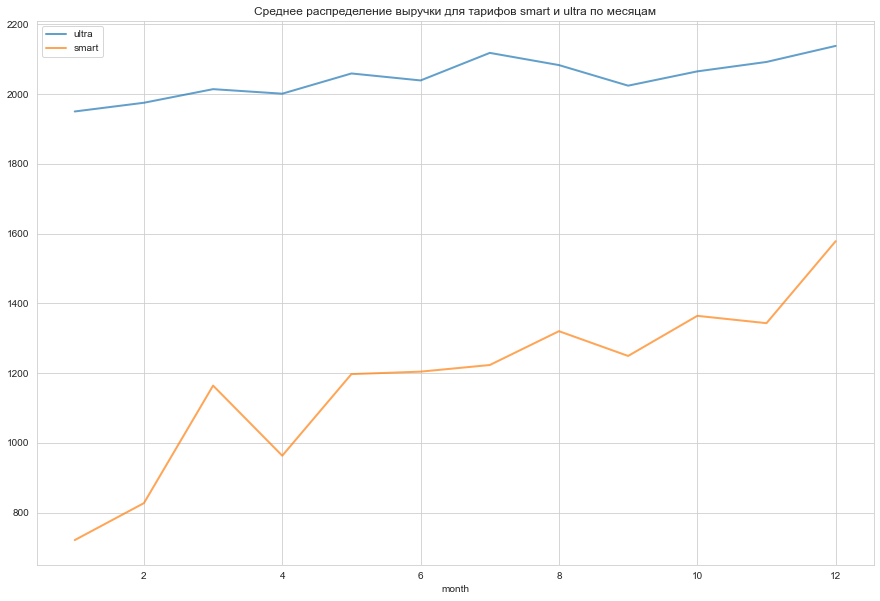

In [68]:
# Составим сводные таблицы, в которых данные будут сгруппированы по месяцам
data_ul = data.query('tariff == "ultra"').pivot_table(index='month', values='revenue_month', aggfunc='mean' ).astype(int)
data_sm = data.query('tariff == "smart"').pivot_table(index='month', values='revenue_month', aggfunc='mean' ).astype(int)

# посмотрим среднее распределение выручки по двум тарифам

ax = data_ul.plot(
    y='revenue_month',
    linewidth=2,
    alpha=0.7,
    label='ultra',
    figsize=(15,10)
)

data_sm.plot(
    y='revenue_month',
    linewidth=2,
    alpha=0.7,
    label='smart',
    ax=ax,
    grid=True,
    legend=True,
) 

plt.title('Среднее распределение выручки для тарифов smart и ultra по месяцам')
plt.show()

In [69]:
#Какова суммарная выручка по тарифам и количество пользователей каждого
data.groupby('tariff').agg({'revenue_month': ('sum', 'count')}).astype(int)

revenue_month      
                 sum count
tariff                    
smart        2875351  2229
ultra        2039100   985

К концу года показатели средней выручки растут. Судя по графику, вручка для тарифов smart выше, чем по тарифу ultra. Несмотря на то, что клиентов ultra в 2,3 раза меньше, чем клиентов smart, выручки они приносят меньше всего в 1,4 раза. 

#### Вывод

Результаты статичтических тестов не противоречат гипотезе, что средняя выручка от пользователей тарифов ultra больше средней выручки от пользователей тарифов smart. Нельзя отвергнуть гипотезу, что средняя выручка от пользователей из Москвы равна выручке от пользователей из других регионов.

## Общий вывод 

Изучили данные 500 пользователей сети Мегалайн за 2018 год.
В ходе работ нужно было установить, какой из тарифов: ultra или smart выгоднее для компании.

Данные были обработаны и для каждого пользователя расчитано сколько минут, смс и гб было использовано в месяц и сколько он потратил на услуги связи, в том числе сверх тарифа. Получили данные, что по тарифу smart выручка, полученная по абонентской плате примерно равна выручке за услуги не включенные в абонентскую плату. По тарифу ultra переплат сверх тарифа меньше - 40% от оплаты по тарифу.

Выяснили, что не используют звонки 1,4% клиентов, не используют смс-сообщения 15.5% клиентов, не используют интернет 0.4% клиентов.

Исследованы данные по каждому тарифу. С наибольшей вероятностью, клиентам нужно около 460 минут разговора в месяц, порядка 45 смс и 17 гб в месяц, в среднем для всех тарифов. 

По тарифу ultra средние значения в месяц:  457 минут, 61 смс, 19 Гб. 
По тарифу smart средние значения в месяц:  419 минут, 38 смс, 16 Гб

По продолжительности звонков и количеству смс распределение с положительной скошенностью и для тарифа smart и для тарифа ultra.
Это означает, что есть пользователи с продолжительностью звонков и количеством смс значительно больше среднего для обоих тарифов. По количеству гб распределение более симметричное. Для тарифа smart с большей вроятностью пользователи выходят за пороговое бесплатное значении тарифа 15 гб.

Распределение для тарифа ultra всегда более пологое, это означает, что разброс значений шире, чем у smart.
По всем показателям стандартное отклонение существенно, волатильность значений высокая и для сопоставления средних важно применить статистический тест.

На заключительном этапе исследования проверяли гипотезы, применяя статистические тесты. Тесты показали, что с высокой степенью вероятности можем утверждать, что средняя выручка от пользователей тарифов ultra и smart отличается и средняя выручка от пользователей тарифов ultra больше smart, а средняя выручка пользователей из Москвы близка выручке пользователей из других регионов. 

Тариф ultra выгоднее для компании, чем тариф smart. Клиентов ultra в 2,3 раза меньше, чем клиентов smart, но выручки они приносят меньше всего в 1,4 раза. К концу года показатели средней выручки растут. 